<a href="https://colab.research.google.com/github/SERVIR/flood_mapping_intercomparison/blob/main/notebooks/Module_1_Data_Availability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prerequisites**

Before taking this module, you must have the following

* A Google Earth Engine Account
* A Google Cloud Project tied to your Google Earth Engine account.
* A Google Drive account.
* Google Colaboratory installed on your Google Drive

# **Introduction**

In this module, we will determine the availability of cloud-free optical data for a flood event of your interest. We are searching for a flood event in which there is a

- Sentinel-1 overpass over the area of interest during the time of interest
- Harmonized Landsat and Sentinel-2 (HLS) overpass over the area of interest during the time of interest
- low prevalence of cloud in all optical sensors used to create flood products (HLS, MODIS, VIIRS).

If we find a suitable flood event, we will export the area within the area of interest in which there is an overlap between the HLS and Sentinel-1 overpass geometries.

## **Step 1: Create GEE Directory**

- 1. Open the [Google Earth Engine Code Editor](https://code.earthengine.google.com/)

- 2. Navigate to the Assets Tab in the upper right.

- 3. Create a new folder by clicking the "New Button". Enter in a name or path for the folder. **This will be our parent folder, and will be where we upload all of the flood products**. My parent folder is called "users/mickymags/flood_intercomparison", but you can call yours whatever you like.

- 4. Create a folder in which to hold each of the flood products within the parent folder by clicking the "New" button, and creating a folder within the parent folder called "mcdwd", "vfm", "dswx", and "gfm" respectively. When you are done, your assets folder should look similar to the bottom of the picture below.



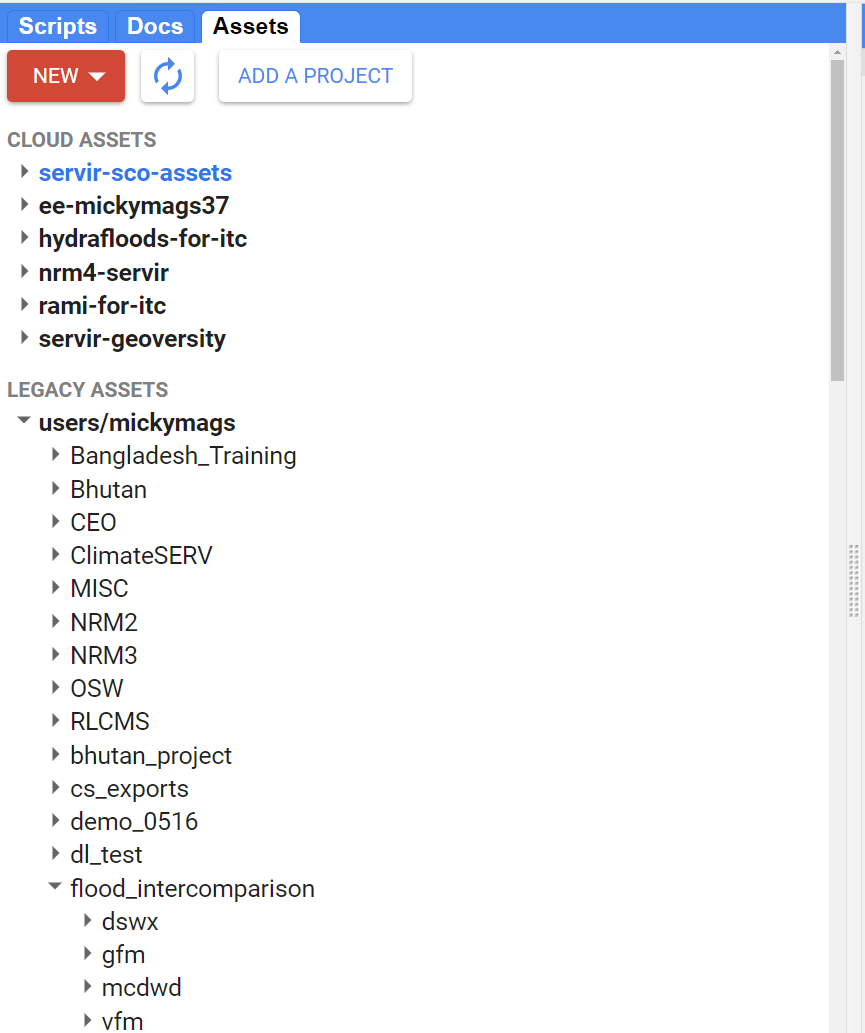





# Step 2: Define Inputs

After modifying the cells below to suit your case study and Earth Engine account, the rest of the cells should run as is.



In [ ]:
# Google Earth Engine Variables
parent_directory = "users/mickymags/flood_intercomparison_morocco_09_09_24/"   # Define the path to the directory you created in step 1. This will either begin with "users/..." or "projects/...""
#parent_directory = "projects/servir-sco-assets/assets/flood_intercomparison/pk_case_study/"
aoi_asset_name = 'aoi'                                        # Define what you want the asset name of your area of interest to be
gee_project_name = "servir-sco-assets"

# Google Drive Variables
#Pick the Google Drive Folder where you want to export the area of interest
# This is an optional folder
gd_folder = ''

# Case Study Variables
doi = "2024-09-09"                                            # Enter the Date of Interest in "YYYY-MM-DD"
country = 'Morocco'                                          # Enter country name as a string
province_list = ''                                           # Leave this as an empty string if using district_list
district_list = 'Tata,Tiznit,Errachidia,Taroudannt'          # Leave this as an empty string if using province_list
#s2_cloud_probability_threshold = 5                           # Enter the cloud probability threshold for Sentinel- 2

# Step 3: Import packages

We need to import a couple packages for this analysis.

1. The Earth Engine package will allow us to obtain data from Earth Engine and perform some operations on the data.
2. The [geemap](https://geemap.org/) Python package allows for further analysis and visualization using Earth Engine data.
3. The Google Drive package will allow us to export imagery and data from this notebook to your Google Drive.


In [ ]:
from google.colab import drive       # Import Google Drive
import ee                            # Import the Earth Engine package
import geemap                        # Import the Google Earth Engine Python package (geemap)

Now we need to Authenticate Earth Engine, and initilaze it.

In [ ]:
ee.Authenticate()
ee.Initialize(project = 'servir-sco-assets')

# Step 4: Get input data


For this project, we want to compare six flood products/software to each other. Some of these have different input datasets from optical and SAR sensors, which we detail below. In this notebook, we will examine the quality assurance infromation from all of the input datasets to determine if a case study is suitable for optical analysis.


* GFM: The Copernicus Global Flood Monitor. For more information see [this website](https://global-flood.emergency.copernicus.eu/technical-information/glofas-gfm/).
  * Input Dataset: Sentinel-1 uses IW GRDH product, which we can obtain from Google Earth Engine
*  TERRA: The Terra product used as input to the MCDWD product has the following DOI a(http://doi.org/10.5067/MODIS/MOD09.NRT.061) (Slayback et al ___). This product is not available in GEE. Thus, we will use a similar MODIS product in order to estimate the cloud cover in the region of interest
* AQUA: The Aqua product used as input to the MCDWD product is not specified. Email sent 09/05/24
* HLS: The HLS product is split into two datasets, one for Sentinel and one for Landsat. The Sentinel HLS product is not currently available on GEE.



In [ ]:
sentinel1 = ee.ImageCollection("COPERNICUS/S1_GRD") # Sentinel-1 Ground Range Detected
hls_landsat = ee.ImageCollection("NASA/HLS/HLSL30/v002")
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
terra = ee.ImageCollection("MODIS/061/MOD09GA")
aqua = ee.ImageCollection("MODIS/061/MYD09GA")
viirs = ee.ImageCollection("NASA/VIIRS/002/VNP09GA")

Let's filter the Sentinel-1 collection to just those images that are used by the GFM flood Product. GFM ingests observations from the Sentinel-1 satellites that are acquired in the Interferometric Wide-swath (IW imaging mode) (Matgen et al 2022). GFM uses the Ground Range Detected at High Resolution (GRDH) product from Sentinel-1 to create the GFM Water Product (Matgen et al 2021).

In [ ]:
# Sentinel-1 Filtered to interferometric width
s1filt = sentinel1.filter(ee.Filter.eq('instrumentMode', 'IW'))\
                  .filter(ee.Filter.eq('resolution', 'H'))          # Filter to High Resolution Scenes

Get a date of interest

In [ ]:
dayafter = ee.Date(doi).advance(1, "day")

Get an area of interest

In [ ]:
gaul = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")

In [ ]:
def region_merger(input_string, column_name):
  area_of_interest = ee.FeatureCollection([])

  splitstring = input_string.split(",")
  feature_list = []
  for v in splitstring:
    feature = gaul.filter(ee.Filter.eq(column_name, v))
    feature_list.append(feature)
  for x in feature_list:
    area_of_interest = area_of_interest.merge(x)

  return area_of_interest

In [ ]:
if len(province_list) == 0:
  aoi = region_merger(district_list, 'ADM2_NAME')
else:
  aoi = region_merger(province_list, 'ADM1_NAME')

In [ ]:
#aoi = gaul.filter(ee.Filter.eq('ADM0_NAME', country)).filter(ee.Filter.eq('ADM1_NAME', district))

In [ ]:
s1final = s1filt.filterDate(doi, dayafter).filterBounds(aoi)

In [ ]:
s1vp = {
    'bands': ['VV'],
    'min': -25,
    'max': 0
}

In [ ]:
s1geom = s1final.geometry()

In [ ]:
hlsl_final = hls_landsat.filterDate(doi, dayafter).filterBounds(aoi)
s2final = s2.filterDate(doi, dayafter).filterBounds(aoi)

#l8c1geom = l8c1final.geometry()
#l8c2geom = l8c2final.geometry()
hlsl_geom = hlsl_final.geometry()
s2geom = s2final.geometry()

# Harmonized Landsat Sentinel Final Geometry
hlsf_geom = hlsl_geom.union(s2geom)

Now we will define aoifinal, the final area of interest. this is the intersection of where our HLS overpass and our Sentinel-1 overpass is.

In [ ]:
aoifinal = hlsf_geom.intersection(s1geom)

In [ ]:
s1_mosaic = s1final.mosaic()

In [ ]:
s1vv_vp = {
    'bands': ['VV', 'VV', 'VV'],
    'min': - 25,
    'max': 0
}

In [ ]:
Map = geemap.Map(center = (13.1, 14.7), zoom = 5)
Map.addLayer(aoi, {}, 'region of interest')
Map.addLayer(s1geom, {}, 'Sentinel-1 Geometry')
Map.addLayer(hlsf_geom, {}, 'HLS Geometry')
Map.addLayer(aoifinal, {}, 'Final Area of Interest -- intersection of HLS and S1')
Map.addLayer(s1_mosaic, s1vv_vp, 'Sentinel1 VV')

Map.addLayerControl()
Map

Map(center=[13.1, 14.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [ ]:
# Create a bounding box around the area of interest
aoibb = aoifinal.bounds()

In [ ]:
aoifc = ee.FeatureCollection(aoifinal)
aoibb_fc = ee.FeatureCollection(aoibb)

# Export Area of Interest to Google Earth Engine Asset
#geemap.ee_export_vector_to_asset(aoifc, description = 'Area of Interest PK Jun 23', assetId= parent_dir2 + aoi_asset_name)

# Export Area of Interest Bounding Box to Google Drive
geemap.ee_export_vector_to_drive(
    aoifc, description = 'Area_of_Interest_Morocco_09_09_24', fileFormat='GeoJSON', folder=gd_folder
)

geemap.ee_export_vector_to_drive(
    aoibb_fc, description = 'BBox_Area_of_Interest_Morocco_09_09_24', fileFormat='GeoJSON', folder=gd_folder
)

Exporting Area_of_Interest_Morocco_09_09_24... Please check the Task Manager from the JavaScript Code Editor.
Exporting BBox_Area_of_Interest_Morocco_09_09_24... Please check the Task Manager from the JavaScript Code Editor.


In [ ]:
#aoifc = ee.FeatureCollection(aoifinal)
#geemap.ee_export_vector_to_asset(aoifc, description='exporting_final_aoi', assetId='projects/servir-sco-assets/flood_intercomparison/pk_case_study/aoi')
geemap.ee_export_vector_to_asset(aoifc, description='exporting_final_aoi', assetId= parent_directory + 'aoi')
geemap.ee_export_vector_to_asset(aoibb_fc, description='exporting_final_aoi_bbox', assetId= parent_directory + 'aoi_bbox')

users/mickymags/flood_intercomparison_morocco_09_09_24/aoi
Exporting exporting_final_aoi... Please check the Task Manager from the JavaScript Code Editor.
users/mickymags/flood_intercomparison_morocco_09_09_24/aoi_bbox
Exporting exporting_final_aoi_bbox... Please check the Task Manager from the JavaScript Code Editor.


Now let's filter all of the optical datasets to overlap with aoifinal.

In [ ]:
terrafilt = terra.filterDate(doi, dayafter).filterBounds(aoifinal).mosaic().clip(aoifinal)
aquafilt = aqua.filterDate(doi, dayafter).filterBounds(aoifinal).mosaic().clip(aoifinal)
viirsfilt = viirs.filterDate(doi, dayafter).filterBounds(aoifinal).mosaic().clip(aoifinal)
hlsl_filt = hls_landsat.filterDate(doi, dayafter).filterBounds(aoifinal).mosaic().clip(aoifinal)
s2filt = s2.filterDate(doi, dayafter).filterBounds(aoifinal).mosaic().clip(aoifinal)

Define the visualization parameters for each optical sensor.

In [ ]:
modis_vp = {
  'bands': ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'],
  'min': 470,
  'max': 2382
}

viirs_vp = {
  'bands': ['I1', 'M4', 'M2'],
  'min': 0.1,
  'max': 0.4,
  'gamma': 1
}

s2_vp = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 1964
}

l8_vp = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.3
}

Depending on overpass times, HLS Landsat or Sentinel-2 may not display below.

In [ ]:
# Get the coordinates of the center of the AOI for mapping purposes
aoi_centroid = aoi.geometry().centroid()             # Get the center of the AOI
lon = aoi_centroid.coordinates().get(0).getInfo()    # Extract the longitude from the centroid
lat = aoi_centroid.coordinates().get(1).getInfo()    # Extract the latitude from the centroid

In [ ]:
Map = geemap.Map(center = (lat, lon), zoom = 5)
Map.addLayer(aoifinal, {}, 'Final Area of Interest -- intersection of HLS and S1')
Map.addLayer(terrafilt, modis_vp, 'TERRA')
Map.addLayer(aquafilt, modis_vp, 'AQUA')
Map.addLayer(viirsfilt, viirs_vp, 'VIIRS')
Map.addLayer(s2filt, s2_vp, 'Sentinel-2')
Map.addLayer(hlsl_filt, l8_vp, 'HLS Landsat')

Map.addLayerControl()
Map

Map(center=[30.576259837319526, -6.6670474839668294], controls=(WidgetControl(options=['position', 'transparen…

# References


- Matgen, Patrick. "Provision of an Automated, Global, Satellite-based Flood Monitoring Product for the Copernicus Emergency Management Service. "GFM D6 Product Definition Document. Issue 1 Version 1.4. April 20, 2022.

- Roger, J.C. et al. "Suomi-NPP VIIRS Surface Reflectance User's Guide". NASA Land SIPS. Version 2.0. April 2023. https://lpdaac.usgs.gov/documents/1657/VNP09_User_Guide_V2.pdf
